# Imports

In [206]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.utils import column_or_1d
from sklearn import linear_model
from scipy.optimize import linprog
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as plt

In [105]:
# Constants
EARNINGS_STEP = 5000
AGE_STEP = 5
EDUC_STEP = 3

# Question 1

In [90]:
# Read the CSV and put 0.0 values to NaN
lalonde_df = pd.read_csv('lalonde.csv', na_values={'re78': 0.0})

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [97]:
# Compute the mean in earnings (1978) for both treatments
np.mean(lalonde_df[lalonde_df['treat'] == 0]['re78']), np.mean(lalonde_df[lalonde_df['treat'] == 1]['re78'])
lalonde_df.axes

[RangeIndex(start=0, stop=614, step=1),
 Index(['id', 'treat', 'age', 'educ', 'black', 'hispan', 'married', 'nodegree',
        're74', 're75', 're78'],
       dtype='object')]

In [128]:
def plot_distribution(attr, step):
    # Remove NaN values and add a category column
    lalonde_attr_df = lalonde_df.dropna(subset=[attr]).copy()
    lalonde_attr_df['category'] = lalonde_attr_df[attr] // step

    # Compute the labels
    categories = np.sort(lalonde_attr_df['category'].unique()) * step
    labels = []
    for i in range(len(categories)):
        current = categories[i]
        if i == len(categories) - 1:
            nextt = '+'
        else:
            nextt = str(int(categories[i+1]))

        labels.append('[%d, %s]' % (current, nextt))

    # Show with a barplot the average (again) with the uncertainty
    g = sb.countplot(y='category', hue='treat', data=lalonde_attr_df)
    g.set(yticklabels=labels)
    
def plot_distribution_binary(attr):
    # Remove NaN values and add a category column
    lalonde_attr_df = lalonde_df.dropna(subset=[attr]).copy()

    # Show with a barplot the average (again) with the uncertainty
    g = sb.countplot(y=attr, hue='treat', data=lalonde_attr_df)

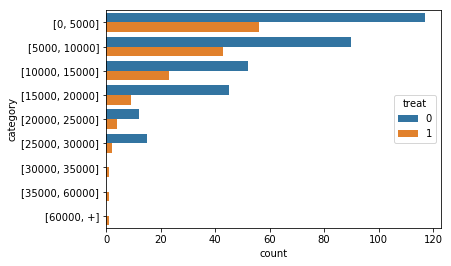

In [106]:
plot_distribution('re78', EARNINGS_STEP)

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

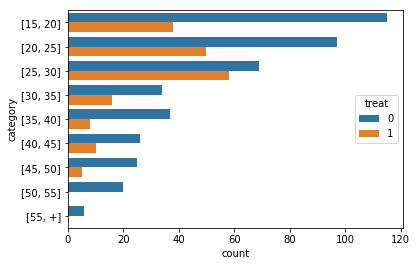

In [107]:
plot_distribution('age', AGE_STEP)

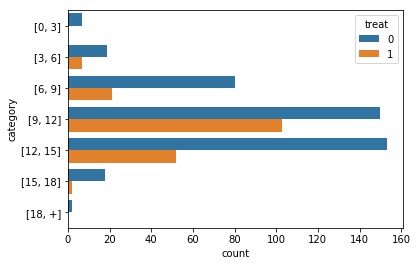

In [108]:
plot_distribution('educ', EDUC_STEP)

None


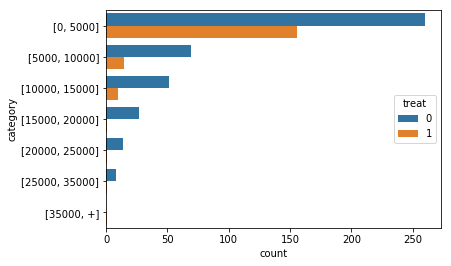

In [118]:
plot_distribution('re74', EARNINGS_STEP)

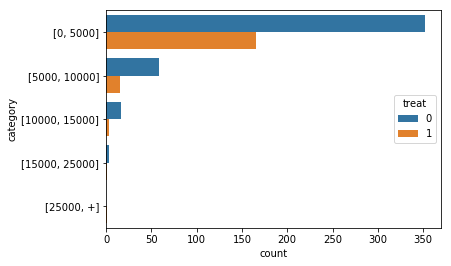

In [126]:
plot_distribution('re75', EARNINGS_STEP)

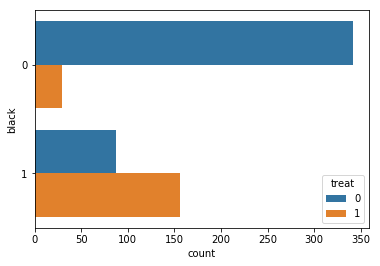

In [129]:
plot_distribution_binary('black')

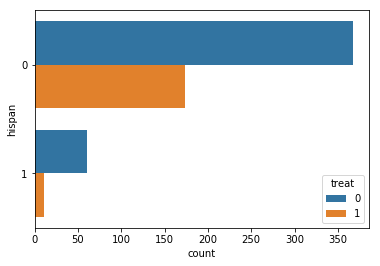

In [131]:
plot_distribution_binary('hispan')

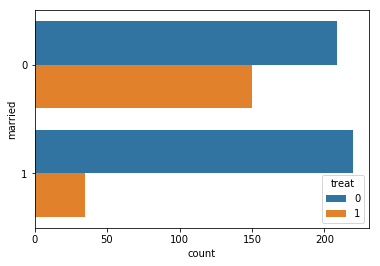

In [132]:
plot_distribution_binary('married')

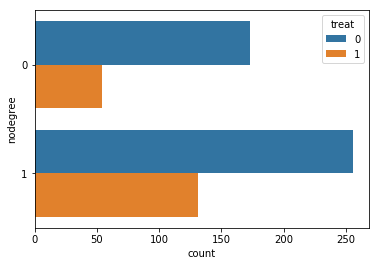

In [133]:
plot_distribution_binary('nodegree')

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [168]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

logistic = linear_model.LogisticRegression()
X = lalonde_df.drop(['id', 'treat', 're78'], axis=1)
y = lalonde_df['treat']
logistic.fit(X, y)
w = logistic.coef_

# Standardize score and compute probability (propensity score) using sigmoid
score = X.dot(w.T)
score = (score - np.mean(score)) / np.std(score)
prob = sigmoid(score)

# DataFrame with propensity score
propensity_df = lalonde_df.copy()
propensity_df['prop_score'] = prob
propensity_df.treat.value_counts()

0    429
1    185
Name: treat, dtype: int64

In [193]:
non_t_size, t_size = propensity_df.treat.value_counts().values

c = []
for score_1 in propensity_df.loc[propensity_df['treat'] == 1, 'prop_score'].values:
    for score_0 in propensity_df.loc[propensity_df['treat'] == 0, 'prop_score'].values:
        c.append(np.abs(score_1 - score_0))

b = []
A1 = []
for i in range(t_size):
    tab = []
    for j in range(len(c)):
        if j >= i * non_t_size and j < (i + 1) * non_t_size:
            tab.append(-1)
        else:
            tab.append(0)
    A1.append(tab)
    b.append(-1)
            
A2 = []
for i in range(non_t_size):
    tab = []
    for j in range(len(c)):
        if (j - i) % non_t_size == 0:
            tab.append(1)
        else:
            tab.append(0)
    A2.append(tab)
    b.append(1)

In [208]:
A = A1+A2

bounds = [(0, None)] * len(c)

res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='interior-point')

ValueError: Unknown solver interior_point

In [205]:
res

     fun: 123.0
 message: 'Optimization failed. Unable to find a feasible starting point.'
     nit: 2000
  status: 2
 success: False
       x: nan

# Question 2

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

## Solution

### Explanation and assumptions

#### Explanation

#### Assumptions

### Data retrieving

We directly load the data using sklearn

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train')

In [3]:
newsgroups_test = fetch_20newsgroups(subset='test')

And we convert the text to vectors taking care of setting a *max_features* parameter in order to have the same number of features in the train and test set.

In [5]:
vectorizer = TfidfVectorizer()
X_test = vectorizer.fit_transform(newsgroups_test.data)
print('Test set shape:', X_test.shape)
max_features = X_test.shape[1]

Test set shape: (7532, 93564)


In [7]:
vectorizer = TfidfVectorizer(max_features=max_features)
X_train = vectorizer.fit_transform(newsgroups_train.data)
print('Training set shape:', X_train.shape)

Training set shape: (11314, 93564)


### Random forest

In [8]:
SCORING = ['accuracy', 'neg_mean_squared_error']

In [9]:
def runCV(clf, X_train, y_train, k):
    scores = cross_validate(clf, X_train, y_train, cv=k, scoring=SCORING, return_train_score=False)
    print_scores(scores)
    return scores
        
def print_scores(scores):
    print('Scores')
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
    print("RMSE: %0.2f (+/- %0.2f)" % (np.sqrt(-scores['test_neg_mean_squared_error']).mean(), scores['test_neg_mean_squared_error'].std() * 2))

With **k-fold cross validation** and **grid_search**, we found that good parameters are:

* n_estimators = 350
* max_depth = 80

Further fine-tuning can be done but we estimated that those parameters were enough considering the long running-time involved in finding the best parameters.

In [12]:
def fine_tuning(depths, estimators):
    best_depth = 0;
    best_estimators = 0;
    best_acc = 0;

    for max_depth in depths:
        for n_estimators in estimators:
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=42,
                n_jobs=-1
            )
            scores = runCV(clf, X_train, newsgroups_train.target, 7)
            acc = scores['test_accuracy'].mean()

            if acc > best_acc:
                best_depth = max_depth
                best_estimators = n_estimators
                best_acc = acc
                
    print('Best parameters are (accuracy of', best_acc, '):')
    print('Depth:', best_depth, 'n_estimators:', best_estimators)
    
    return best_depth, best_etimators

In [13]:
fine_tuning([75, 80, 85], [350, 400])

Scores
Accuracy: 0.85 (+/- 0.01)
RMSE: 2.67 (+/- 1.67)
Scores
Accuracy: 0.85 (+/- 0.01)
RMSE: 2.67 (+/- 1.54)
Scores
Accuracy: 0.85 (+/- 0.00)
RMSE: 2.69 (+/- 1.52)
Scores
Accuracy: 0.85 (+/- 0.01)
RMSE: 2.68 (+/- 1.87)


KeyboardInterrupt: 

In [ ]:
max_depth = 80
n_estimators = 350

In [ ]:
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
clf.fit(X_train, newsgroups_train.target)

### Model assessment

In [ ]:
#acc = accuracy_score(newsgroups_test.target, clf.predict(X_test))
clf.predict(X_test)
#print('Accuracy:', acc * 100)